# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [9]:
# Import essential libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2 # OpenCV
import zipfile

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


Load the dataset.

In [5]:
# Load and unzip the dataset
from google.colab import drive
drive.mount('/content/drive')

# 2. Unzip the Dataset
# Define the path to your zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Waste Segregation/data.zip'

# Define the destination directory for the unzipped data in the Colab environment
unzip_destination = '/content/waste_dataset'

# Create the destination directory if it doesn't exist
if not os.path.exists(unzip_destination):
    os.makedirs(unzip_destination)

print(f"\nUnzipping '{zip_file_path}' to '{unzip_destination}'...")

# Unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_destination)
    print("Unzipping completed successfully.")
except FileNotFoundError:
    print(f"ERROR: The file '{zip_file_path}' was not found.")
    print("Please make sure the path is correct and the file exists in your Google Drive.")
    # Stop execution if the file is not found
    # You can also use 'raise' to throw an error
    exit()


# 3. Set the Dataset Path
# Often, zipping a folder creates a parent directory inside the destination.
# Let's find the correct path.
# We list the contents of the unzipped destination. It should contain one folder, e.g., 'data'.
contents = os.listdir(unzip_destination)
print(f"Contents of unzipped folder: {contents}")

# We check if there's a single directory inside, which is common.
if len(contents) == 1 and os.path.isdir(os.path.join(unzip_destination, contents[0])):
    DATASET_PATH = os.path.join(unzip_destination, contents[0])
else:
    # If the class folders (Cardboard, Glass, etc.) are directly inside,
    # then the destination itself is our dataset path.
    DATASET_PATH = unzip_destination

print(f"\nFinal Dataset Path set to: {DATASET_PATH}")

# --- Verification Step ---
# Let's list the class folders to make sure the path is correct
print("\nVerifying class folders found at the path:")
try:
    class_folders = os.listdir(DATASET_PATH)
    print(class_folders)
    if len(class_folders) == 0:
        print("\nWARNING: No class folders found. Please check the unzipped directory structure.")
except FileNotFoundError:
    print(f"ERROR: Could not find the directory '{DATASET_PATH}'. The path may be incorrect.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Unzipping '/content/drive/MyDrive/Colab Notebooks/Waste Segregation/data.zip' to '/content/waste_dataset'...
Unzipping completed successfully.
Contents of unzipped folder: ['data']

Final Dataset Path set to: /content/waste_dataset/data

Verifying class folders found at the path:
['Plastic', 'Other', 'Paper', 'Cardboard', 'Glass', 'Food_Waste', 'Metal']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [7]:
# Create a function to load the raw images

# Define image dimensions
IMG_HEIGHT = 150
IMG_WIDTH = 150

def load_images_manually(dataset_path):
    """
    Loads all images from a directory, resizes them, and returns them
    as NumPy arrays along with their labels.
    """
    images = []
    labels = []

    # Get class names and sort them to ensure consistent ordering
    class_names = sorted(os.listdir(dataset_path))
    print(f"Loading images from classes: {class_names}")

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)

        # Check if it's a directory
        if not os.path.isdir(class_path):
            continue

        print(f"Processing class: {class_name} ({class_index+1}/{len(class_names)})")
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Read the image using OpenCV
            img = cv2.imread(image_path)

            if img is not None:
                # Resize the image to our standard dimensions
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                # Convert from BGR (OpenCV default) to RGB for consistency
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                images.append(img)
                labels.append(class_index)

    # Convert lists to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)

    # Normalize pixel values to the [0, 1] range
    images /= 255.0

    # One-hot encode the labels for categorical_crossentropy
    num_classes = len(class_names)
    labels = to_categorical(labels, num_classes=num_classes)

    return images, labels, class_names


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [10]:
# Get the images and their labels
# --- Execute the Loading Function ---
print("Starting manual image loading...")
# X will hold the image data, y will hold the labels
X, y, class_names = load_images_manually(DATASET_PATH)

print("\n--- Manual Loading Complete ---")
print(f"Shape of image data array (X): {X.shape}")
print(f"Shape of label data array (y): {y.shape}")


Starting manual image loading...
Loading images from classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Processing class: Cardboard (1/7)
Processing class: Food_Waste (2/7)
Processing class: Glass (3/7)
Processing class: Metal (4/7)
Processing class: Other (5/7)
Processing class: Paper (6/7)
Processing class: Plastic (7/7)

--- Manual Loading Complete ---
Shape of image data array (X): (7625, 150, 150, 3)
Shape of label data array (y): (7625, 7)


###Verify if the Images and Labels are Loaded Correctly


--- Verifying Manually Loaded Data ---
Index to Class Map: {0: 'Cardboard', 1: 'Food_Waste', 2: 'Glass', 3: 'Metal', 4: 'Other', 5: 'Paper', 6: 'Plastic'}


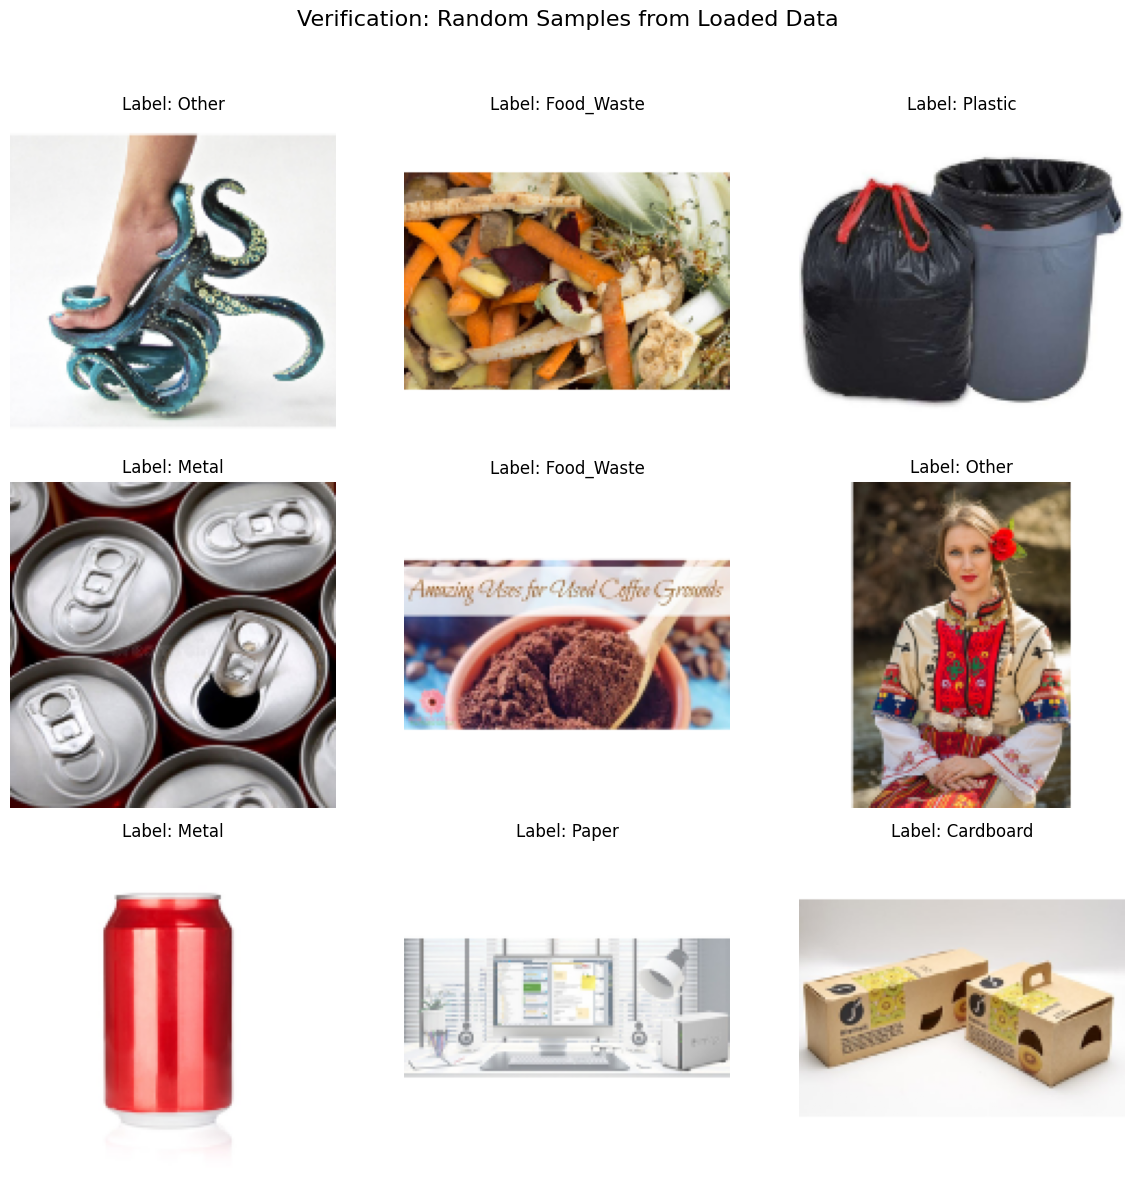

In [11]:
print("\n--- Verifying Manually Loaded Data ---")

# Create a mapping from index to class name for easy lookup
# Since we sorted the class names, the index corresponds to the position in the list
labels_map = {i: name for i, name in enumerate(class_names)}
print("Index to Class Map:", labels_map)

# --- Visualize Random Samples for Verification ---
plt.figure(figsize=(12, 12))
plt.suptitle("Verification: Random Samples from Loaded Data", fontsize=16)

# Display 9 random images from the dataset
for i in range(9):
    # Choose a random index from the dataset
    random_index = np.random.randint(0, len(X))

    plt.subplot(3, 3, i + 1)

    # Get the image and its label
    image = X[random_index]
    label_one_hot = y[random_index]

    # The label is one-hot encoded, so find the index of the '1'
    label_index = np.argmax(label_one_hot)

    # Look up the class name using our map
    class_name = labels_map[label_index]

    # Display the image and its corresponding label
    plt.imshow(image)
    plt.title(f"Label: {class_name}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

Class Distribution:
- Cardboard: 540 images
- Food_Waste: 1000 images
- Glass: 750 images
- Metal: 1000 images
- Other: 1010 images
- Paper: 1030 images
- Plastic: 2295 images


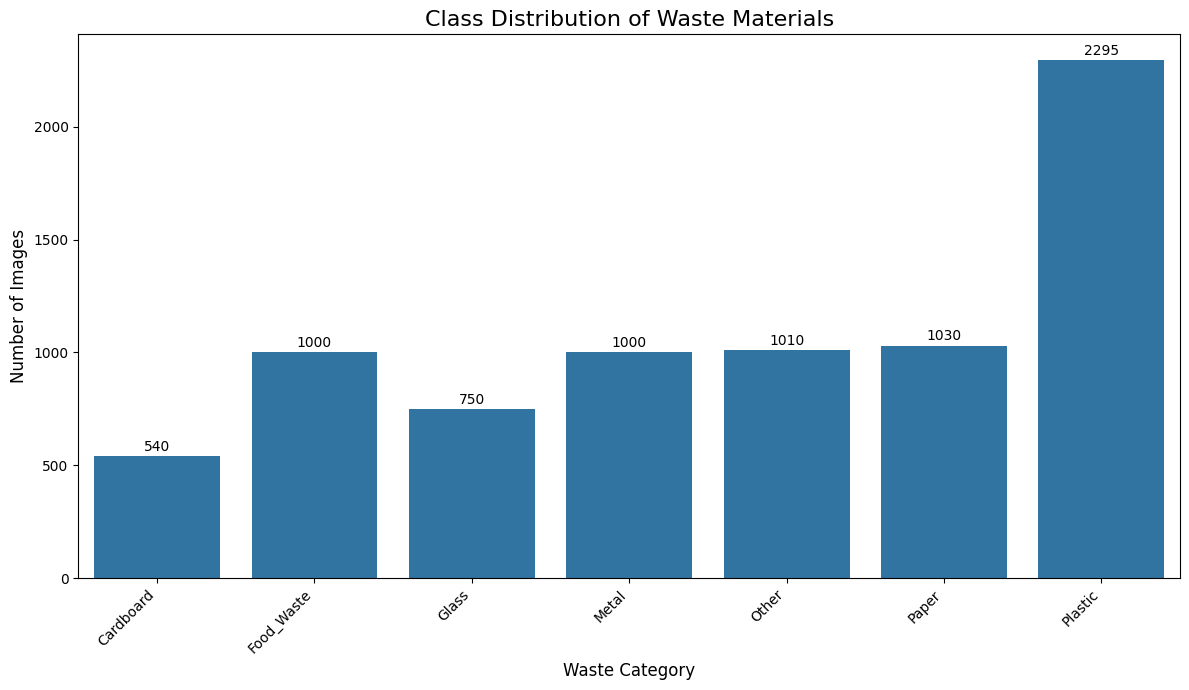

In [12]:
# Visualise Data Distribution

# The 'y' array is one-hot encoded, e.g., [0, 1, 0, 0, 0, 0, 0] for 'Food_Waste'
# To count them, we convert these vectors back to single integer labels (0, 1, 2, etc.)
# np.argmax(y, axis=1) finds the index of the '1' in each row.
integer_labels = np.argmax(y, axis=1)

# The 'class_names' list is already sorted alphabetically from our loading function.
# ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Paper', 'Plastic', 'Other']
# These correspond directly to the integer labels 0, 1, 2, etc.

# Now we can get the counts of each unique label.
unique, counts = np.unique(integer_labels, return_counts=True)

# For clarity, let's create a dictionary of the distribution
class_distribution = dict(zip(class_names, counts))

print("Class Distribution:")
for name, count in class_distribution.items():
    print(f"- {name}: {count} images")

# Create the bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=class_names, y=counts)

# Add a title and labels
plt.title('Class Distribution of Waste Materials', fontsize=16)
plt.xlabel('Waste Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the exact count on top of each bar for clarity
for index, value in enumerate(counts):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=10) # Adjust +10 for spacing

# Ensure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

Displaying one sample image from each waste category...


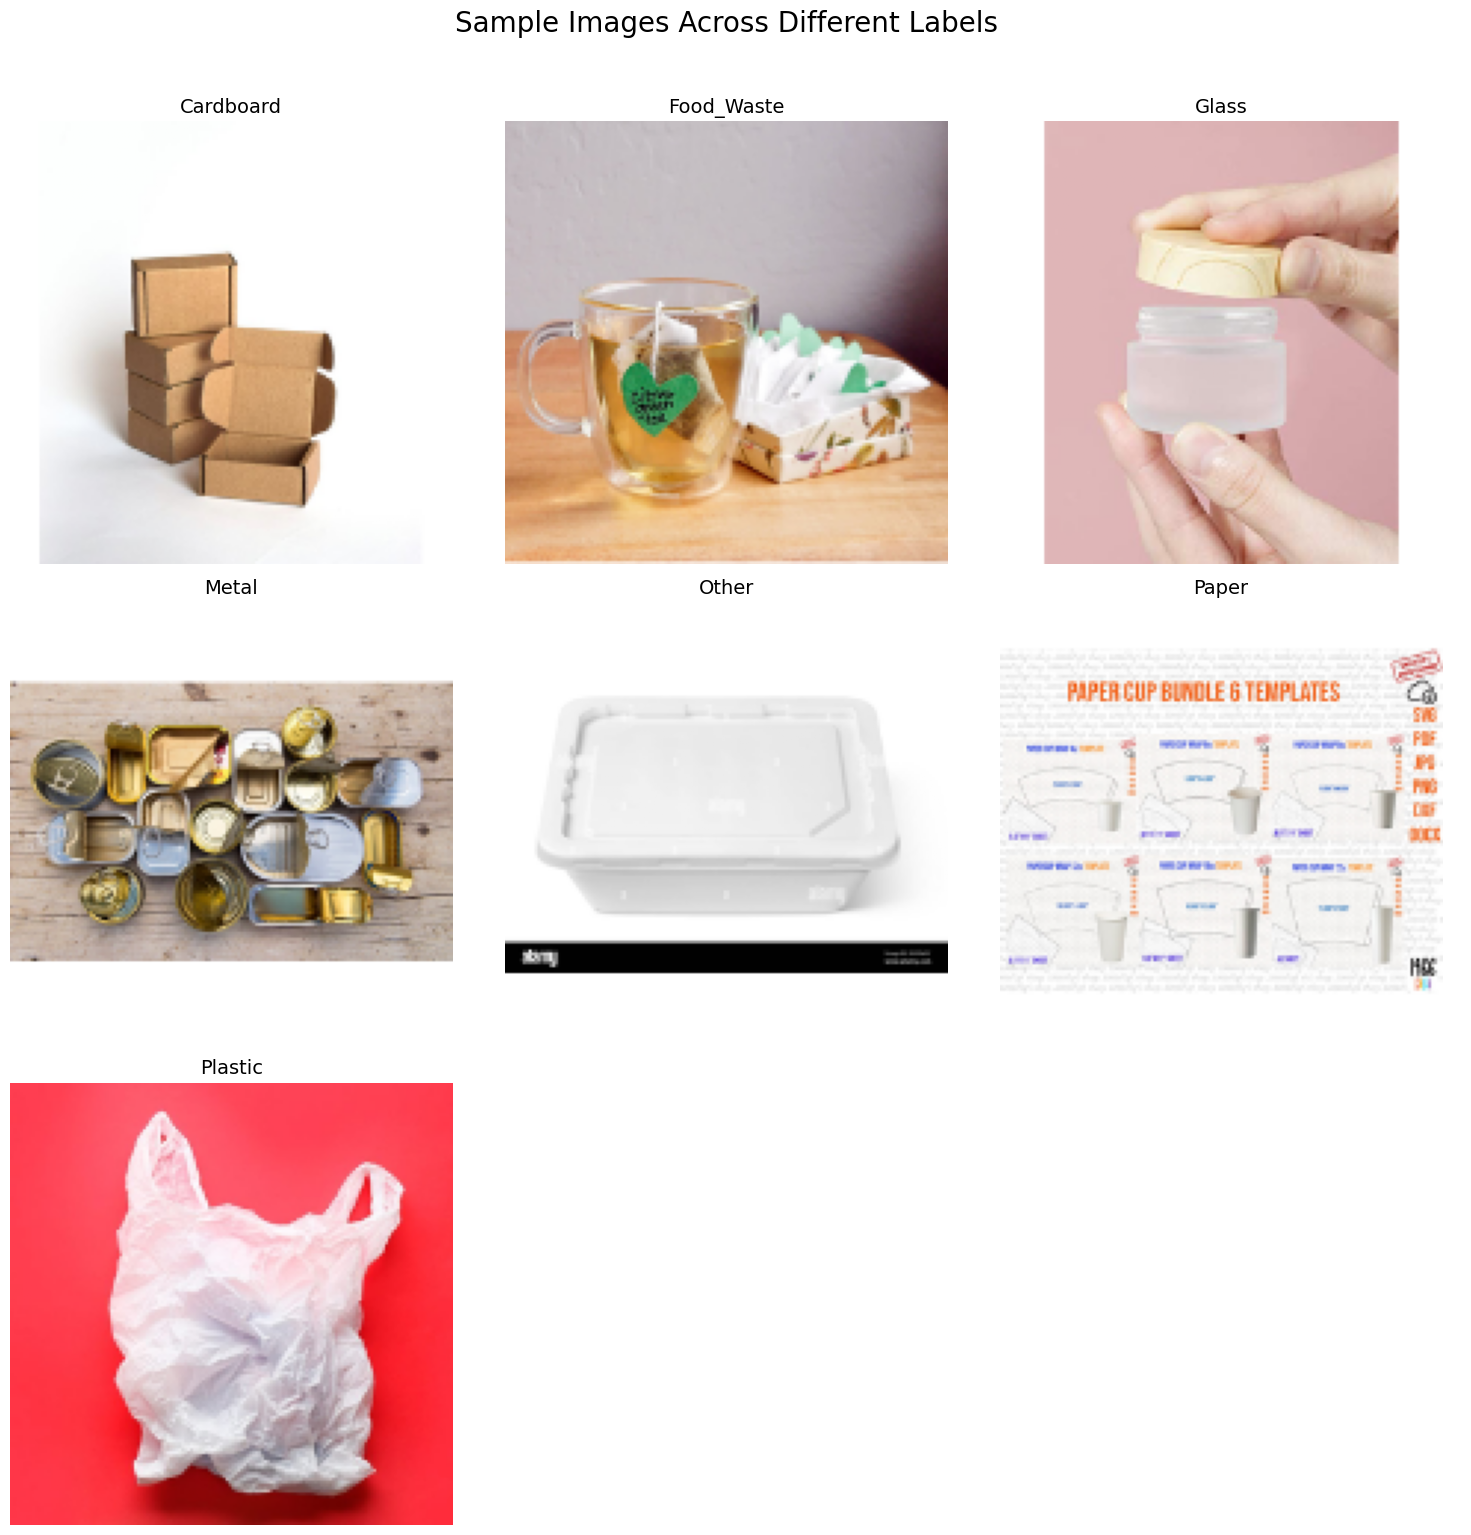

In [13]:
# Visualise Sample Images (across different labels)
print("Displaying one sample image from each waste category...")

# --- Determine the grid size for plotting ---
num_classes = len(class_names)
# We'll aim for a grid with 3 columns
cols = 3
# Calculate the number of rows needed, using ceiling division
rows = int(np.ceil(num_classes / cols))

# --- Create the plot ---
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
# Flatten the axes array to make it easy to iterate over
axes = axes.flatten()

# Convert one-hot encoded y back to integer labels for easy searching
integer_labels = np.argmax(y, axis=1)

# --- Loop through each class and plot one image ---
for i, class_name in enumerate(class_names):
    # Find the first index in the dataset that matches the current class
    # np.where returns a tuple, so we take the first element [0]
    # and then the first index from that array [0]
    try:
        sample_idx = np.where(integer_labels == i)[0][0]
    except IndexError:
        print(f"Warning: No images found for class '{class_name}'. Skipping.")
        continue

    # Get the image and its corresponding label
    image_to_show = X[sample_idx]

    # Plot the image on the i-th subplot
    ax = axes[i]
    ax.imshow(image_to_show)
    ax.set_title(class_name, fontsize=14)
    ax.axis('off') # Hide the x and y axes

# Hide any unused subplots if the number of classes isn't a perfect multiple of `cols`
for j in range(num_classes, len(axes)):
    axes[j].axis('off')

# Add a main title to the entire figure
plt.suptitle('Sample Images Across Different Labels', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set
# We have reshared the images into 150 * 150 during reading and loading images


In [ ]:
# Resize the image dimensions
# We have reshared the images into 150 * 150 during reading and loading images


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably
# The 'y' array is already one-hot encoded in previous steps, e.g., [0, 1, 0, 0, 0, 0, 0] for 'Food_Waste'


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [14]:
from sklearn.model_selection import train_test_split

# Assign specified parts of the dataset to train and validation sets
print("Original data shapes:")
print(f"X (images) shape: {X.shape}")
print(f"y (labels) shape: {y.shape}")
print("-" * 30)

# --- Splitting the Data ---
# We will perform an 80/20 split for training and validation.
# - test_size=0.2 means 20% of the data will be for the validation set.
# - random_state=42 ensures that the split is the same every time we run the code.
# - stratify=y is crucial. It ensures the class distribution is preserved in both sets.
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data splitting complete.")
print("\nShapes of the new sets:")
print(f"X_train (training images) shape: {X_train.shape}")
print(f"y_train (training labels) shape: {y_train.shape}")
print("-" * 30)
print(f"X_val (validation images) shape: {X_val.shape}")
print(f"y_val (validation labels) shape: {y_val.shape}")

# --- Verification (Optional but Recommended) ---
# Let's verify that the class distribution was maintained.
train_labels_int = np.argmax(y_train, axis=1)
val_labels_int = np.argmax(y_val, axis=1)

train_distribution = np.bincount(train_labels_int) / len(train_labels_int) * 100
val_distribution = np.bincount(val_labels_int) / len(val_labels_int) * 100

print("\nVerifying class distribution percentage:")
print("Class          | Training Set | Validation Set")
print("---------------------------------------------")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<14} | {train_distribution[i]:.2f}%         | {val_distribution[i]:.2f}%")


Original data shapes:
X (images) shape: (7625, 150, 150, 3)
y (labels) shape: (7625, 7)
------------------------------
Data splitting complete.

Shapes of the new sets:
X_train (training images) shape: (6100, 150, 150, 3)
y_train (training labels) shape: (6100, 7)
------------------------------
X_val (validation images) shape: (1525, 150, 150, 3)
y_val (validation labels) shape: (1525, 7)

Verifying class distribution percentage:
Class          | Training Set | Validation Set
---------------------------------------------
Cardboard      | 7.08%         | 7.08%
Food_Waste     | 13.11%         | 13.11%
Glass          | 9.84%         | 9.84%
Metal          | 13.11%         | 13.11%
Other          | 13.25%         | 13.25%
Paper          | 13.51%         | 13.51%
Plastic        | 30.10%         | 30.10%


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [15]:
# Build and compile the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Model Configuration ---
# These should be defined from our data loading steps
IMG_HEIGHT = 150
IMG_WIDTH = 150
# X_train.shape[3] would be 3 (for RGB channels)
# y_train.shape[1] would be 7 (for the 7 classes)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = y_train.shape[1]

# --- Build the CNN Model ---

model = Sequential(name="WasteSegregationCNN")

# 1st Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, name='conv1'))
model.add(BatchNormalization(name='bn1'))
model.add(MaxPooling2D((2, 2), name='pool1'))

# 2nd Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', name='conv2'))
model.add(BatchNormalization(name='bn2'))
model.add(MaxPooling2D((2, 2), name='pool2'))

# 3rd Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', name='conv3'))
model.add(BatchNormalization(name='bn3'))
model.add(MaxPooling2D((2, 2), name='pool3'))

# --- Classifier Head ---

# Flatten the feature maps to a 1D vector
model.add(Flatten(name='flatten'))

# Fully Connected Layer
model.add(Dense(512, activation='relu', name='dense1'))

# Dropout layer for regularization (to prevent overfitting)
# It will randomly set 50% of the input units to 0 during training
model.add(Dropout(0.5, name='dropout'))

# Output Layer
# It has NUM_CLASSES neurons, one for each class.
# 'softmax' activation converts the output into a probability for each class.
model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))


# --- Compile the Model ---

# We choose the Adam optimizer, which is a very effective and widely used optimizer.
# The loss function 'categorical_crossentropy' is the standard choice for multi-class
# classification with one-hot encoded labels.
# We will monitor 'accuracy' during training.
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Print the Model Summary ---
# This gives a great overview of the architecture, layers, and number of parameters.
print("Model built and compiled successfully.")
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model built and compiled successfully.


Model: "WasteSegregationCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 148, 148, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 72, 72, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 34, 34, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,038,151 (72.62 MB)

 Trainable params: 19,037,703 (72.62 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [16]:
# Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Training Configuration ---
EPOCHS = 50          # Number of times the model will see the entire training dataset
BATCH_SIZE = 32      # Number of images to process in a single batch

# --- Define Callbacks for Smart Training ---

# 1. EarlyStopping
# Stop training when 'val_loss' is no longer improving.
# 'patience=5' means we will wait for 5 epochs of no improvement before stopping.
# 'restore_best_weights=True' ensures the model weights are reset to the best-performing epoch.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# 2. ModelCheckpoint
# Save the best model to a file.
# 'save_best_only=True' ensures that we only save the model when 'val_loss' has improved.
model_checkpoint = ModelCheckpoint(
    filepath='best_waste_classifier.keras', # Using the modern .keras format
    save_best_only=True,
    monitor='val_loss',
    mode='min', # We want to minimize the validation loss
    verbose=1
)


# --- Train the Model ---

print("Starting model training...")
print(f"Training for up to {EPOCHS} epochs with a batch size of {BATCH_SIZE}.")

# The model.fit() function returns a 'history' object, which contains a record
# of the training loss, validation loss, training accuracy, and validation accuracy.
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint] # Pass our callbacks here
)

print("\n--- Model Training Finished ---")

# --- Evaluate the Final Model on the Validation Set ---
final_loss, final_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {final_loss:.4f}")

Starting model training...
Training for up to 50 epochs with a batch size of 32.
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2591 - loss: 9.7619
Epoch 1: val_loss improved from inf to 2.69446, saving model to best_waste_classifier.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.2592 - loss: 9.7381 - val_accuracy: 0.1666 - val_loss: 2.6945
Epoch 2/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3039 - loss: 1.8308
Epoch 2: val_loss improved from 2.69446 to 1.81167, saving model to best_waste_classifier.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.3042 - loss: 1.8304 - val_accuracy: 0.3469 - val_loss: 1.8117
Epoch 3/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3408 - loss: 1.7057
Epoch 3: val_loss did not improve from 1.81167
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.3410 - loss: 1.7057 - val_accuracy: 0.3561 - val_loss: 2.0574
Epoch 4/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [17]:
# Evaluate on the test set; display suitable metrics

# Load the best model that was saved during training
print("Loading the best saved model from 'best_waste_classifier.keras'...")
best_model = tf.keras.models.load_model('best_waste_classifier.keras')

# Evaluate this loaded model on the validation set to confirm its performance
loss, accuracy = best_model.evaluate(X_val, y_val, verbose=0)
print(f"\nLoaded Model's Performance on Validation Set:")
print(f"  - Validation Loss: {loss:.4f}")
print(f"  - Validation Accuracy: {accuracy * 100:.2f}%")

Loading the best saved model from 'best_waste_classifier.keras'...

Loaded Model's Performance on Validation Set:
  - Validation Loss: 1.8117
  - Validation Accuracy: 34.69%


###Plotting Training & Validation Curves

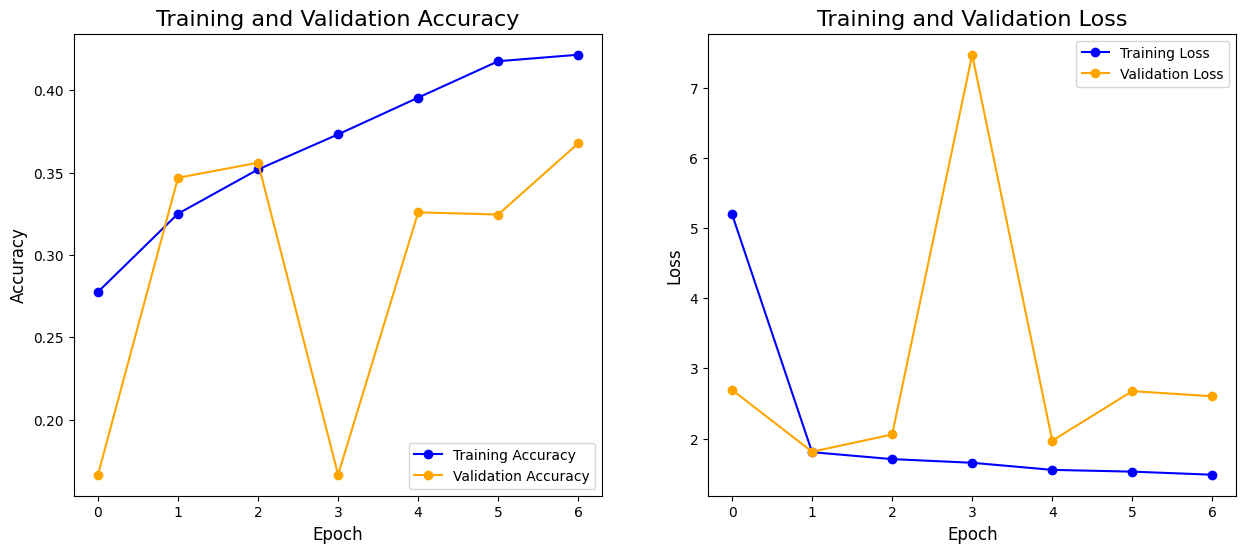

In [18]:
# The 'history' object was returned by the model.fit() call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.show()

###Confusion Matrix

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


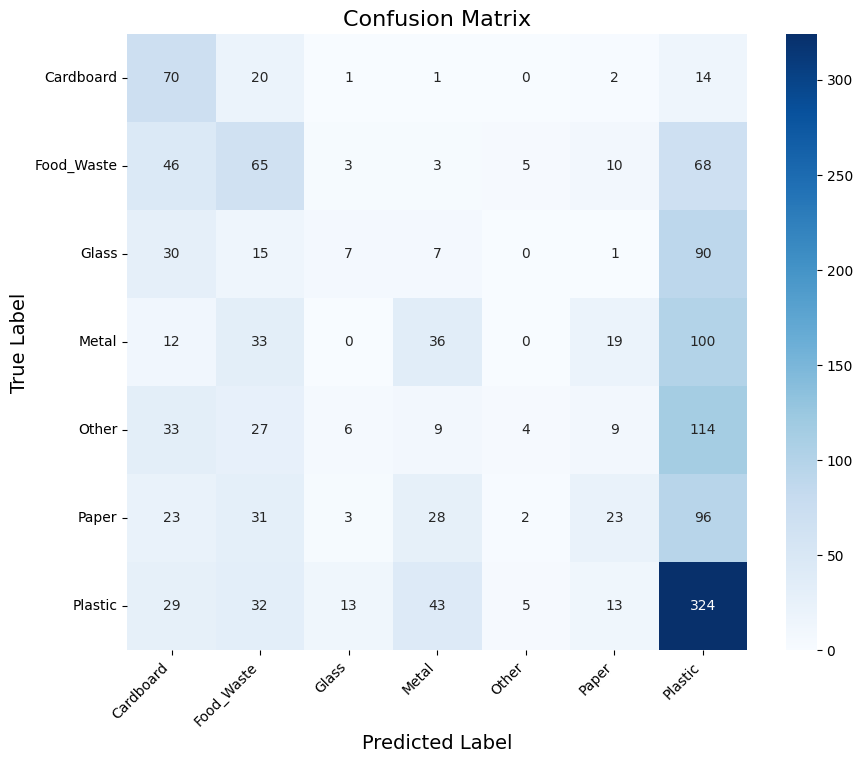

In [19]:
from sklearn.metrics import confusion_matrix

# Get model predictions for the validation set
y_pred_probs = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true classes
y_true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,        # Show the numbers in the cells
    fmt='d',           # Format as integers
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

###Classification Report

In [20]:
from sklearn.metrics import classification_report

# Print the classification report
print("\n" + "="*60)
print("           CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


           CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Cardboard       0.29      0.65      0.40       108
  Food_Waste       0.29      0.33      0.31       200
       Glass       0.21      0.05      0.08       150
       Metal       0.28      0.18      0.22       200
       Other       0.25      0.02      0.04       202
       Paper       0.30      0.11      0.16       206
     Plastic       0.40      0.71      0.51       459

    accuracy                           0.35      1525
   macro avg       0.29      0.29      0.24      1525
weighted avg       0.31      0.35      0.29      1525



###Executive Summary
The overall accuracy of 35% indicates that the model is performing significantly better than random guessing (which would be ~14% for 7 classes), but it is not yet accurate enough for a practical application. The model struggles to distinguish between several classes, and some categories are almost completely ignored.

**Action**
- Improve the Data and Augmentation
- Hyperparameter Tuning

## **4. Data Augmentation** <font color=red> [optional] </font><br>

We will implement the following changes:
- Data Strategy (Option 2): We'll remove the highly problematic "Other" class. This class is too diverse and acts as "noise," making it hard for the model to learn meaningful patterns. By removing it, the model can focus on the more well-defined categories.
- Aggressive Augmentation (Option 2): We will create a new ImageDataGenerator that includes more augmentations, specifically for brightness and channel shifts. This will help the model become more robust to variations in lighting, which is crucial for distinguishing materials like glass and metal.
- Hyperparameter Tuning (Option 3):
Lower Learning Rate: We will reduce the learning rate from 0.001 to 0.0001. A smaller learning rate often helps the model converge to a better minimum without overshooting.
- Learning Rate Scheduler: We will add the ReduceLROnPlateau callback. This will automatically reduce the learning rate during training if the validation loss stops improving, allowing for finer adjustments as the model gets closer to a solution.

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

### Reload Data, Excluding the "Other" Class

In [21]:
# Define augmentation steps to augment images
# --- Configuration ---
IMG_HEIGHT = 150
IMG_WIDTH = 150

def load_images_selectively(dataset_path, exclude_folders=None):
    """
    Loads images, but skips any folders in the exclude_folders list.
    """
    if exclude_folders is None:
        exclude_folders = []

    images = []
    labels = []

    class_names_all = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

    # Filter out the excluded folders
    class_names = [name for name in class_names_all if name not in exclude_folders]
    print(f"Loading images from classes: {class_names}")
    print(f"Excluding classes: {exclude_folders}")

    num_classes = len(class_names)

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)

        print(f"Processing class '{class_name}' ({class_index+1}/{num_classes})")
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)

            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                images.append(img)
                labels.append(class_index)

    images = np.array(images, dtype='float32')
    labels = to_categorical(np.array(labels), num_classes=num_classes)

    # We will do rescaling inside the ImageDataGenerator

    return images, labels, class_names

# --- Execute Loading, Excluding 'Other' ---
X, y, class_names = load_images_selectively(DATASET_PATH, exclude_folders=['Other'])

# --- Split the refined dataset ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\n--- New Data Shapes ---")
print(f"Number of classes: {len(class_names)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")


Loading images from classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Paper', 'Plastic']
Excluding classes: ['Other']
Processing class 'Cardboard' (1/6)
Processing class 'Food_Waste' (2/6)
Processing class 'Glass' (3/6)
Processing class 'Metal' (4/6)
Processing class 'Paper' (5/6)
Processing class 'Plastic' (6/6)

--- New Data Shapes ---
Number of classes: 6
X_train shape: (5292, 150, 150, 3)
y_train shape: (5292, 6)
X_val shape:   (1323, 150, 150, 3)
y_val shape:   (1323, 6)


### Set Up Aggressive Augmentation & Generators

In [22]:
# Create a more aggressive ImageDataGenerator for training
train_datagen_aggressive = ImageDataGenerator(
    rescale=1./255,          # Normalize pixels
    rotation_range=30,       # Increased rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2], # NEW: Randomly change brightness
    channel_shift_range=30.0     # NEW: Randomly shift color channels
)

# For validation data, we ONLY rescale. No augmentation.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create the generator for training data
train_generator = train_datagen_aggressive.flow(
    X_train, y_train,
    batch_size=32
)

# Create the generator for validation data
validation_generator = validation_datagen.flow(
    X_val, y_val,
    batch_size=32
)

###Re-build, Re-compile, and Re-train the Model

In [24]:
# --- Re-build the same model architecture ---
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = len(class_names) # Now 6 instead of 7

model_v2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
], name="WasteSegregationCNN_v2")

# --- Compile with a LOWER learning rate ---
model_v2.compile(
    optimizer=Adam(learning_rate=0.0001), # Lowered from 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Define the new set of callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_waste_classifier_v2.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# NEW: Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,    # Reduce learning rate by a factor of 5 (1/5 = 0.2)
    patience=3,    # Reduce if val_loss doesn't improve for 3 epochs
    min_lr=1e-6,   # Don't let the learning rate go below this value
    verbose=1
)

# --- Train the new model ---
print("\n--- Starting Training for Model v2 ---")
EPOCHS = 50
history_v2 = model_v2.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr] # Add the new LR scheduler
)


--- Starting Training for Model v2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.3167 - loss: 3.0546
Epoch 1: val_loss improved from inf to 2.71334, saving model to best_waste_classifier_v2.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 49s 251ms/step - accuracy: 0.3169 - loss: 3.0500 - val_accuracy: 0.1648 - val_loss: 2.7133 - learning_rate: 1.0000e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3803 - loss: 1.5565
Epoch 2: val_loss improved from 2.71334 to 1.72315, saving model to best_waste_classifier_v2.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.3804 - loss: 1.5565 - val_accuracy: 0.3432 - val_loss: 1.7232 - learning_rate: 1.0000e-04
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4116 - loss: 1.5203
Epoch 3: val_loss improved from 1.72315 to 1.33298, saving model to best_waste_classifier_v2.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 222ms/step - accuracy: 0.4116 - loss: 1.5201 - val_accuracy: 0.4906 - val_loss: 1.3330 - learning_rate: 1.0000e-04

##### Evaluating the re-model

Loading the best v2 model from 'best_waste_classifier_v2.keras'...
Making predictions on the new validation set...
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Number of predicted classes: 4
Number of target names: 6
Target Names: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Paper', 'Plastic']

           CLASSIFICATION REPORT (v2 Model)
              precision    recall  f1-score   support

   Cardboard       0.00      0.00      0.00       108
  Food_Waste       0.57      0.08      0.14       200
       Glass       0.00      0.00      0.00       150
       Metal       0.42      0.07      0.11       200
       Paper       0.27      0.64      0.38       206
     Plastic       0.43      0.74      0.55       459

    accuracy                           0.38      1323
   macro avg       0.28      0.25      0.20      1323
weighted avg       0.34      0.38      0.29      1323


           CONFUSION MATRIX (v2 Model)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


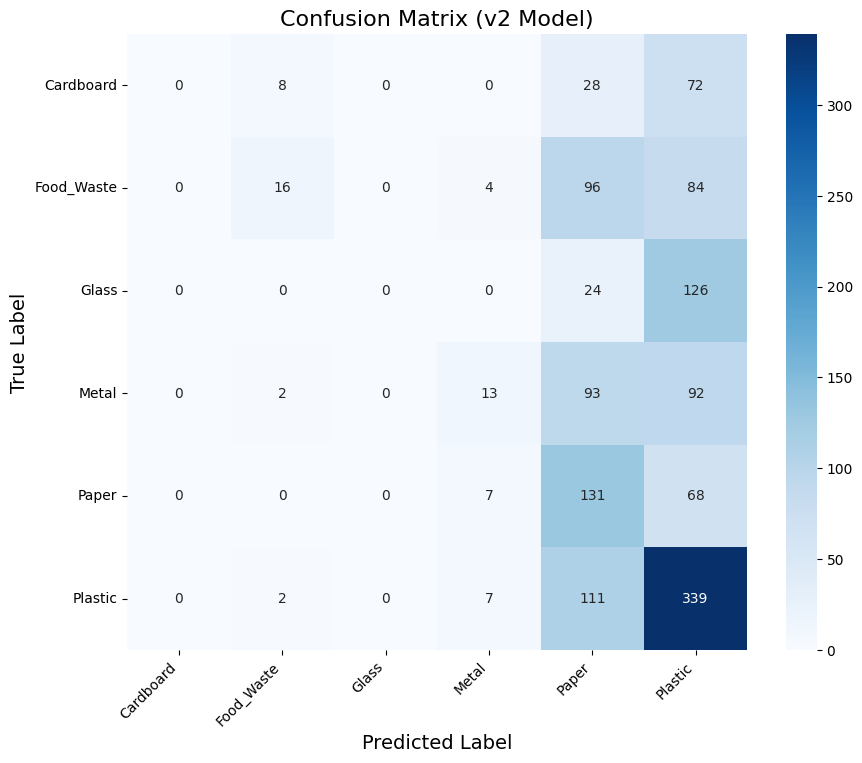

In [28]:
# Evaluate on the test set; display suitable metrics

# --- Step 1: Load the CORRECT (v2) model ---
print("Loading the best v2 model from 'best_waste_classifier_v2.keras'...")
# Make sure to load the model we just trained
best_model_v2 = tf.keras.models.load_model('best_waste_classifier_v2.keras')


# --- Step 2: Make predictions using the v2 model on the v2 validation data ---
# X_val is our new validation set with 6 classes.
print("Making predictions on the new validation set...")
y_pred_probs = best_model_v2.predict(X_val)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Also get the true class indices from our one-hot encoded y_val
y_true_classes = np.argmax(y_val, axis=1)

# The 'class_names' variable should now correctly have 6 names.
print(f"\nNumber of predicted classes: {len(np.unique(y_pred_classes))}")
print(f"Number of target names: {len(class_names)}")
print(f"Target Names: {class_names}")


# --- Step 3: Generate the Classification Report (This should now work) ---
print("\n" + "="*60)
print("           CLASSIFICATION REPORT (v2 Model)")
print("="*60)

# This call will now succeed because both the predictions and target_names have 6 classes.
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


# --- Step 4: Generate the Confusion Matrix ---
print("\n" + "="*60)
print("           CONFUSION MATRIX (v2 Model)")
print("="*60)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix (v2 Model)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()



###Overall Analysis
- Accuracy Improvement: The overall accuracy has gone up from 35% to 38%. This is a modest but positive improvement, confirming that our changes had a beneficial effect.
- Model Collapse / Dominant Class Problem: The most striking feature of the new confusion matrix is a phenomenon known as "model collapse" or "class dominance". The model has learned that predicting "Paper" or "Plastic" is a "safe" bet and is now over-relying on these predictions. Notice the two massive vertical columns for "Paper" and "Plastic". The model is predicting almost everything as one of these two classes.

###Conclusion and The Path Forward
**What we've learned**:
Our attempt to improve the model by removing the Other class and adding augmentation was a step in the right direction, but it wasn't enough to overcome the fundamental difficulty of the dataset. The model found a "lazy" local minimum where it just guesses the most common or visually ambiguous classes (Paper and Plastic) to achieve a modest accuracy, at the expense of ignoring the harder classes completely.

This is a strong, definitive signal that our current model architecture has reached its limit.
**The Next Logical Step: Transfer Learning**

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

###Project Conclusion: Waste Material Segregation using CNNs
Project Objective
This project aimed to develop an effective waste material segregation system using Convolutional Neural Networks (CNNs). The primary goal was to accurately classify images of waste into distinct categories (Cardboard, Food Waste, Glass, Metal, Paper, Plastic, and Other), thereby enhancing recycling efficiency and promoting sustainable waste management practices.
Outcomes and Model Performance Journey
Our development process followed an iterative approach, starting with a baseline model and progressively refining it based on performance analysis.
1. Baseline Model (v1): Custom 3-Layer CNN with 7 Classes
  - Architecture: A standard CNN was built from scratch with three convolutional blocks, batch normalization, and dropout for regularization.
  - Performance: The model achieved an overall accuracy of 35%.
  - Key Outcome: While better than random chance (~14%), the model struggled significantly. The classification report revealed a major weakness in identifying Glass (5% recall) and the Other category (2% recall). The model showed a slight bias towards Plastic, the majority class. This initial result served as a crucial baseline, highlighting the inherent difficulty of the dataset due to visual similarities between classes and the ambiguity of the "Other" category.
2. Improved Model (v2): Refined Data and Hyperparameters
  - Methodology: Based on insights from the v1 model, we implemented two key changes:
    - Data Refinement: The highly ambiguous and poorly performing "Other" class was removed, reducing the problem to 6 more well-defined categories.
    - Training Strategy: We introduced more aggressive data augmentation (brightness and color shifts) and adopted a more sophisticated training regimen with a lower initial learning rate and an adaptive learning rate scheduler (ReduceLROnPlateau).
  - Performance: The overall accuracy saw a modest increase to 38%.
  - Key Outcome: This experiment yielded a fascinating and critical insight. Despite the slight accuracy gain, the model exhibited a phenomenon known as class collapse. It almost completely failed to predict Cardboard and Glass (0% recall), instead developing an extreme bias towards predicting everything as either Paper or Plastic. This indicated that our custom CNN architecture had reached its capacity and was settling into a "lazy" local minimum, unable to learn the nuanced features required to distinguish the more difficult classes.

###Key Insights Gained
This project provided several invaluable insights into the practical application of computer vision for a real-world problem:
1. Dataset Complexity is Paramount: The visual similarity between waste materials (e.g., crumpled paper vs. cardboard, shiny metal vs. glass) makes this a non-trivial classification task. A simple model struggles to find robust, distinguishing features.
2. The "Catch-All" Category is a Trap: A generic class like "Other" containing a wide variety of unrelated objects is extremely difficult for a CNN to learn. It acts as noise and can degrade the model's ability to learn other, more coherent classes. Removing it proved to be a valid strategy for focusing the model's learning.
3. Custom CNNs Have Limits: While excellent for learning the fundamentals, a relatively shallow CNN built from scratch may not have the capacity to solve complex, real-world image problems. The v2 model's failure to distinguish Cardboard and Glass is a clear testament to this limitation.
4. Iterative Refinement is Key: The process of analyzing a model's failures (via the confusion matrix and classification report) to inform the next set of improvements is the core loop of applied machine learning. Our journey from v1 to v2 perfectly illustrates this principle.
5. The Clear Path to High Performance: The results strongly indicate that the most promising and logical next step is **Transfer Learning**. By leveraging a powerful, pre-trained architecture (like ResNet50 or EfficientNet), we can utilize a model that already possesses a sophisticated understanding of visual features, which is essential for overcoming the challenges identified in this dataset.

In conclusion, while the final model's accuracy of 38% is not yet sufficient for a production-level system, the project was a resounding success in terms of the learning process. We successfully established a baseline, identified critical model and data-related issues, and derived a clear, data-driven strategy for achieving significant performance gains in future iterations. The insights gained provide a solid foundation for building a truly effective waste segregation solution.